In [1]:
import pandas as pd
import numpy as np
from data_analysis import get_heart_bounds, correlation_coef, graph_3d, graph_cc_distribution, graph_dist_over_axis
from BayesOptLib.bayes_opt.bayesian_optimization import BayesianOptimization
from RandomSampler import RandomSampler
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics.pairwise import euclidean_distances
matplotlib.use('Qt5Agg')  # or can use 'TkAgg', whatever you have/prefer
from prettytable import PrettyTable
%matplotlib qt 


def get_index(label):
    """
    Gets the idx of a label in the labels array
    :param label: label to check for
    :return: idx
    """
    idx = 0
    for coord in labels:
        if np.array_equal(label, coord):
            break
        idx += 1
    return idx


def black_box(x, y, z):
    """
    Represents a black box function to maximize for CC of two ECGs given an XYZ coordinate
    :param x:
    :param y: coordinates of the prediction
    :param z:
    :return: CC of that point and the target
    """
    sample_ecg = ecgs[get_index(np.array([x, y, z]))]
    return np.abs(correlation_coef(target_ecg, sample_ecg))


def plot_exploration(visited, color_gradient):
    """
    Handles plotting the predictions of the network over time
    :param visited:
    :return:
    """
    path = np.array(visited)
    color_gradient = np.array(color_gradient)


    # Plot final for viewing
    rest = np.delete(labels, np.where(np.isin(labels, path)), axis=0)
    color_gradient = np.delete(color_gradient, np.where(np.isin(labels, path)), axis=0)
#     fig = plt.figure(0)
    fig = plt.figure(figsize=(8,8)); ax = Axes3D(fig)
    ax = fig.gca(projection='3d')

    ax.scatter(xs=rest[:, 0], ys=rest[:, 1], zs=rest[:, 2], zdir='z', alpha=0.75, c=color_gradient, cmap = plt.cm.Reds)
    ax.scatter(xs=path[:, 0], ys=path[:, 1], zs=path[:, 2], zdir='z', color='blue')
    ax.plot(path[:, 0], path[:, 1], path[:, 2], color = 'blue')

    m = path
    for i in range(len(m)):
        ax.text(m[i, 0], m[i, 1], m[i, 2], '%s' % (str(i)), size=10, zorder=1, color='k')
    ax.scatter(xs=target[0], ys=target[1], zs=target[2], color='black', s = 100)
    plt.show()



In [2]:
# if __name__ == '__main__':
    # Read in ECGs and Coordinates
ecgs = pd.read_csv("simu-data/Heart3_SimuData.csv", header=None).to_numpy()
labels = pd.read_csv("simu-data/Heart3_XYZsub.csv", header=None).to_numpy() / 1000
print(ecgs.shape)
# Get bounds of the heart mesh
bounds = get_heart_bounds()

(2000, 7212)


In [3]:
def optimize_point(labels):
    # Build the optimizer with the heart bounds
    optimizer = BayesianOptimization(
        f=black_box,
        pbounds=bounds,
        random_state=None, real_set=labels
    )

    # Maximize over x number of points
    optimizer.maximize(init_points=10, n_iter=35,  acq="ucb", kappa = 2)
    return optimizer


In [4]:
# Pick out a sample to use as a target
tidx = np.random.randint(0, labels.shape[0])
#tidx = 1
target, target_ecg = labels[tidx], ecgs[tidx]
print("Target: ", target)

# Remove target from labels
#labels = np.delete(labels, np.where(np.isin(labels, target)), axis=0)

# Get plots of target CC distribution
# graph_cc_distribution(target_ecg)
# graph_dist_over_axis(target_ecg)

# Optimize for target and plot path
optimizer = optimize_point(labels)

Target:  [ 80.58325    -83.54884375 -84.06858594]
|   iter    |  target   |     x     |     y     |     z     |
-------------------------------------------------------------
|  1        |  0.8009   |  83.09    | -105.5    | -70.59    |
|  2        |  0.5637   |  62.44    | -111.4    | -59.39    |
|  3        |  0.3288   |  43.77    | -17.49    | -60.73    |
|  4        |  0.8945   |  91.7     | -86.49    | -78.9     |
|  5        |  0.1211   |  59.65    | -22.4     | -7.983    |
|  6        |  0.1486   | -33.7     | -87.87    | -37.19    |
|  7        |  0.1617   |  12.12    | -66.24    | -15.4     |
|  8        |  0.4625   |  41.46    | -23.13    | -53.62    |
|  9        |  0.05381  | -1.271    | -23.1     | -50.78    |
|  10       |  0.1016   |  47.36    | -18.38    | -5.249    |
|  11       |  0.8008   |  81.8     | -105.3    | -69.65    |
|  12       |  0.8024   |  81.13    | -104.6    | -69.15    |
|  13       |  0.8772   |  92.38    | -87.35    | -80.6     |
|  14       |  0.840

In [5]:
init =10
actual = np.asarray(optimizer.predicted)
approx = np.asarray(optimizer.visited)
approx = approx[len(approx)-len(actual):len(approx),:]


In [7]:
# np.linalg.norm(target[1,:]-optimizer.visited[1,:])
# optimizer.visited.shape

In [15]:
def trend(target,visited,actual):
    visited = np.asarray(visited)
    actual = np.asarray(actual)
    visited = visited[len(visited)-len(actual):len(visited)]
    dis_tar_act = []
    dis_tar_vis = []
    dis_dif = []
    for i in range(len(actual)):
        d1 = np.linalg.norm(target-visited[i,:])
        dis_tar_vis = np.append(dis_tar_vis,d1)
        d2 = np.linalg.norm(target-actual[i,:])
        dis_tar_act = np.append(dis_tar_act,d2)
        d3 = np.linalg.norm(actual[i,:]-visited[i,:])
        dis_dif = np.append(dis_dif,d3)
    plt.plot(dis_tar_vis,label = 'between target and visited')
    plt.plot(dis_tar_act,label = 'between target and actual')
    plt.plot(dis_dif, label = 'between predicted and visited')
    plt.xlabel("iteration")
    plt.ylabel("distance")
    plt.legend(loc='upper right')
    plt.show
    

# dis_array = []
# for i in range(len(actual)):
#     d = np.linalg.norm(approx[i,:]-actual[i,:])
#     dis_array = np.append(dis_array,d)

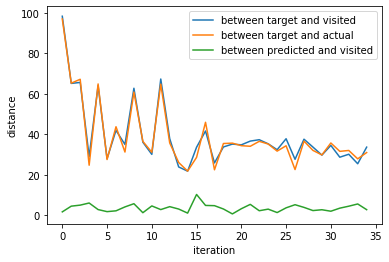

In [16]:
trend(target,optimizer.visited,optimizer.predicted)

In [10]:
plt.plot(dis_array)
plt.show

NameError: name 'dis_array' is not defined

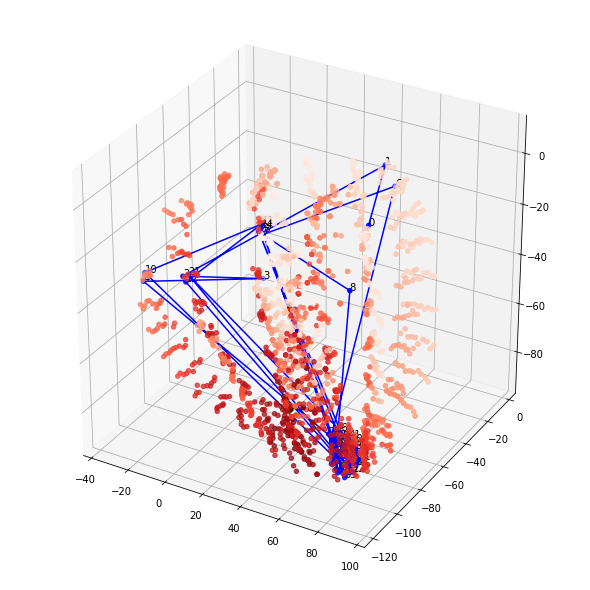

In [11]:
color_gradient = []
# Loop through all points to get CC with that point
for ecg, coord in zip(ecgs, labels):
    if np.array_equal(target_ecg, ecg):
        true = coord
        color_gradient.append(1)
        continue

    cc = correlation_coef(target_ecg, ecg)
    color_gradient.append(cc)

plot_exploration(optimizer.visited, color_gradient)

+-------+--------+--------+----------+------+
|   x   |   y    |   z    | Distance | Corr |
+-------+--------+--------+----------+------+
| 51.57 | -77.75 | -29.71 |   0.0    | 1.0  |
| 50.71 | -85.08 | -20.76 |   11.6   | 0.69 |
| 45.02 | -70.72 | -21.0  |  12.97   | 0.96 |
|  50.9 | -82.1  | -22.68 |   8.29   | 0.87 |
| 51.57 | -77.75 | -29.71 |   0.0    | 1.0  |
| 52.33 | -85.48 | -24.01 |   9.64   | 0.81 |
| 45.74 | -71.97 | -20.28 |   12.5   | 0.96 |
| 45.46 | -73.3  | -19.95 |  12.35   | 0.96 |
| 52.61 | -88.33 | -22.66 |  12.75   | 0.68 |
| 58.21 | -87.21 | -36.26 |  13.28   | 0.97 |
| 58.44 | -87.98 | -34.65 |  13.28   | 0.97 |
| 58.77 | -89.54 | -34.32 |  14.56   | 0.96 |
| 58.83 | -85.99 | -38.13 |  13.84   | 0.96 |
| 41.56 | -78.29 | -39.54 |  14.04   | 0.89 |
| 43.39 | -80.94 | -41.85 |  14.98   | 0.89 |
| 40.12 | -78.7  | -39.31 |  14.97   | 0.88 |
| 45.21 | -70.41 | -22.25 |  12.25   | 0.96 |
| 44.61 | -75.25 | -18.02 |  13.84   | 0.83 |
| 50.56 | -77.72 | -27.58 |   2.36

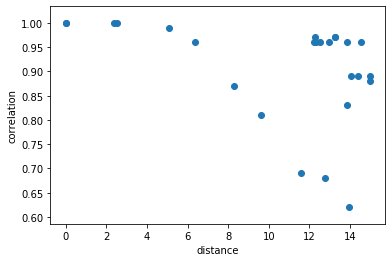

In [43]:
def nearest(tidx,labels,ecgs,dis_limit):
    target_loc = labels[tidx]
    target_ecg = ecgs[tidx]
    cc = np.array([[1]])
    dis = np.array([[0]])
    first_row=np.concatenate((target_loc.reshape(1,3), dis,cc),axis =1)
    nn_loc = np.empty((0, 3))
    nn_cc = np.empty ((0,1))
    nn_dis = np.empty((0,1))
    for i in range(len(labels)):
        d = np.sqrt(np.sum((target_loc - labels[i])**2))
        if d < dis_limit:
            nn_loc = np.append(nn_loc,labels[i].reshape(1,3),axis=0)
            nn_cc = np.append(nn_cc,np.corrcoef(target_ecg, ecgs[i])[0, 1])
            nn_dis = np.append(nn_dis,d)
    nn_dis = nn_dis.reshape(-1,1)
    nn_cc = nn_cc.reshape(-1,1)
    near_points = np.concatenate((nn_loc, nn_dis, nn_cc),axis =1)
    table = np.concatenate((first_row,near_points), axis = 0)
    table = np.around(table,2)
    return table
table=nearest(tidx,labels,ecgs,15)
plt.scatter(table[:,3],table[:,4])
plt.xlabel("distance")
plt.ylabel("correlation")
plt.show
x= PrettyTable()
x.field_names = ['x', 'y','z','Distance','Corr']
for row in table:
    x.add_row(row)
print(x)

In [6]:
cor_matrix = np.corrcoef(ecgs)

In [64]:
def corrplot3axes(tidx,labels,ecgs,dis_limit):
    target_loc = labels[tidx]
    target_ecg = ecgs[tidx]
    target_x,target_y, target_z = target_loc[0],target_loc[1],target_loc[2]
    cc = np.array([[1]])
    dis = np.array([[0]])
    first_row=np.concatenate((target_loc.reshape(1,3), dis,cc),axis =1)
    nn_loc = np.empty((0, 3))
    nn_cc = np.empty ((0,1))
    nn_dis = np.empty((0,1))
    for i in range(len(labels)):
        d = np.sqrt(np.sum((target_loc - labels[i])**2))
        if d < dis_limit:
            nn_loc = np.append(nn_loc,labels[i].reshape(1,3),axis=0)
            nn_cc = np.append(nn_cc,np.corrcoef(target_ecg, ecgs[i])[0, 1])
            nn_dis = np.append(nn_dis,d)
    nn_dis = nn_dis.reshape(-1,1)
    nn_cc = nn_cc.reshape(-1,1)
    near_points = np.concatenate((nn_loc, nn_dis, nn_cc),axis =1)
    x,y,z=[],[],[]
    for j in range(len(near_points)):
        xx=abs(near_points[j,0] - target_loc[0])
        yy=abs(near_points[j,1] - target_loc[1])
        zz=abs(near_points[j,2] - target_loc[2])
        x = np.append(x,xx)
        y = np.append(y,yy)
        z = np.append(z,zz)
    fig, axs = plt.subplots(3)
    axs[0].scatter(x,nn_cc,color = 'green',label = 'x axis')
    axs[0].legend()
    axs[1].scatter(y,nn_cc,color = 'red',label = 'y axis')
    axs[1].legend()
    axs[2].scatter(z,nn_cc,color = 'blue',label = 'z axis')
    axs[2].legend()
#     fig, axs = plt.subplots(num=10, clear=True)
    plt.show
    return x,y,z,nn_cc

In [65]:
table = nearest(tidx,labels,ecgs,10)
table

NameError: name 'nearest' is not defined

In [66]:
x,y,z,nn_cc = corrplot3axes(tidx,labels,ecgs,15)

In [58]:
def plot_exploration(visited, color_gradient):
    """
    Handles plotting the predictions of the network over time
    :param visited:
    :return:
    """
    path = np.array(visited)
    color_gradient = np.array(color_gradient)

    # Plot final for viewing
    rest = np.delete(labels, np.where(np.isin(labels, path)), axis=0)
    color_gradient = np.delete(color_gradient, np.where(np.isin(labels, path)), axis=0)
    fig = plt.figure(0)
    ax = fig.gca(projection='3d')

    ax.scatter(xs=rest[:, 0], ys=rest[:, 1], zs=rest[:, 2], zdir='z', alpha=0.75, c=color_gradient, cmap = plt.cm.Reds)
    ax.scatter(xs=path[:, 0], ys=path[:, 1], zs=path[:, 2], zdir='z', color='blue')
    ax.plot(path[:, 0], path[:, 1], path[:, 2], color = 'blue')

    m = path
    for i in range(len(m)):
        ax.text(m[i, 0], m[i, 1], m[i, 2], '%s' % (str(i)), size=10, zorder=1, color='k')
    ax.scatter(xs=target[0], ys=target[1], zs=target[2], color='black', s = 100)
    plt.show()


In [6]:
color_gradient = []
    # Loop through all points to get CC with that point
for ecg, coord in zip(ecgs, labels):
    if np.array_equal(target_ecg, ecg):
        true = coord
        color_gradient.append(1)
        continue

    cc = correlation_coef(target_ecg, ecg)
    color_gradient.append(cc)
# %matplotlib notebook
plot_exploration(optimizer.visited, color_gradient)

In [ ]:
def graph_cc_distribution(target_loc,target,limit,g_labels,g_ecgs):
    true, blue, green, yellow, red = None, [], [], [], []
    color_gradient = []
    ecgs = np.empty((0, 7212))
    labels = np.empty((0, 3))
    for i in range(len(g_labels)):
        d = np.sqrt(np.sum((target_loc - g_labels[i])**2))
        if d < limit:
            labels = np.append(labels,g_labels[i].reshape(1,3),axis=0)
            ecgs = np.append(ecgs,g_ecgs[i].reshape(1,7212),axis=0)
    for ecg, coord in zip(ecgs, labels):
        if np.array_equal(target, ecg):
            true = coord
            color_gradient.append(1)
            continue

        cc = correlation_coef(target, ecg)
        color_gradient.append(cc)
        if cc >= .9:
            blue.append(coord)
        elif .9 > cc >= .75:
            green.append(coord)
        elif .75 > cc > .3:
            yellow.append(coord)
        else:
            red.append(coord)

    # Plot out the points according to color
    fig = plt.figure(55)
    ax = fig.add_subplot(111, projection='3d')
#     ax = fig.gca(projection='3d')
    ax.scatter(true[0], true[1], true[2], color='black')
    ax.scatter(xs=labels[:, 0], ys=labels[:, 1], zs=labels[:, 2], c=color_gradient, cmap = plt.cm.autumn)
    ax.scatter(true[0], true[1], true[2], color='black', marker = "X", s = 100)
    ax.set_xlabel("X"), ax.set_ylabel("Y"), ax.set_zlabel("Z")
    for angle in range(0, 360):
        ax.view_init(30, angle)
        plt.draw()
        plt.pause(.001)
    fig.show()
#     return labels

In [ ]:
graph_cc_distribution(target,target_ecg,50,labels,ecgs)

In [97]:
def test(target,limit,g_labels,g_ecgs):
    true, blue, green, yellow, red = None, [], [], [], []
    color_gradient = []
    ecgs = np.empty((0, 7212))
    labels = np.empty((0, 3))
    for i in range(len(g_labels)):
        d = np.sqrt(np.sum((target - g_labels[i])**2))
        if d < limit:
            labels = np.append(labels,g_labels[i].reshape(1,3),axis=0)
            ecgs = np.append(ecgs,g_ecgs[i].reshape(1,7212),axis=0)
    return labels,ecgs

In [98]:
labels,ecgs=test(target,10,labels,ecgs)

In [108]:
target_ecg

array([5.88000000e-15, 1.01528000e-05, 7.95080000e-05, ...,
       2.31613333e-01, 2.20140000e-01, 2.08898667e-01])